**Source**  
[UCI source](http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)  
[Data folder](http://archive.ics.uci.edu/ml/machine-learning-databases/00235/)

Georges Hebrail (georges.hebrail '@' edf.fr), Senior Researcher, EDF R&D, Clamart, France
Alice Berard, TELECOM ParisTech Master of Engineering Internship at EDF R&D, Clamart, France

**Data Set Information**  

This archive contains **2075259** measurements gathered in a house located in Sceaux (7 km of Paris, France) between **December 2006** and **November 2010** (**47 months**).  

**Notes:**  
  1. The expression **(1000/60)*GlobalActivePower - S1 - S2 - S3**  
  represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
  2. The dataset contains some missing values in the measurements (nearly **1.25% of the rows**).  
  All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing:  
  a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information**

  1. **date**: Date in format **dd/mm/yyyy**
  2. **time**: time in format **hh:mm:ss**
  3. **GlobalActivePower**: household global minute-averaged active power (in **kilowatt**)
  4. **GlobalReactivePower**: household global minute-averaged reactive power (in **kilowatt**)
  5. **Voltage**: minute-averaged voltage (in **volt**)
  6. **GlobalIntensity**: household global minute-averaged current intensity (in **ampere**)
  7. **S1**: energy sub-metering No. 1 (in **watt-hour** of active energy).  
  It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
  8.  **S2**: energy sub-metering No. 2 (in **watt-hour** of active energy).  
  It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
  9.  **S3**: energy sub-metering No. 3 (in **watt-hour** of active energy).  
  It corresponds to an electric water-heater and an air-conditioner.
 
**Relevant Papers**

N/A


**Citation Request**

This dataset is made available under the “Creative Commons Attribution 4.0 International (CC BY 4.0)” license
  

### General setup

Submetering 1: $S_1$ $[Wh]$, corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave.  
Submetering 2: $S_2$ $[Wh]$, corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
Submetering 3: $S_3$ $[Wh]$, corresponds to an electric water-heater and an air-conditioner.  
Global active power: $P_{active}$ $[kW]$, household global minute-averaged active power.  
  
Active energy consumed: $E_{active}$ $[Wh]$ corresponds to the active energy consumed every minute by electrical equipment not measured in $S_1$, $S_2$ and $S_3$ and is described by:  

$$E_{active} = S_4 = \frac{1000}{60}P_{active} - (S_1 + S_2 + S_3)$$

## Analytics approach
  * Timeframe aggregated predictions

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from householddata import load_and_preprocess_data
from householddata import attach_shifted_series
from householddata import metadata_list

sns.set_style(style='whitegrid')

metadata = metadata_list()
dayofweek = metadata[4]
months = metadata[5]
hourofday = metadata[6]

powerdata = load_and_preprocess_data()
print(np.isnan(powerdata.S4).any())
powerdata.info()

/home/dreuter/Github/kaggle-paths/household-power/data/power-data.zip
already exists, file not downloaded
txt file already exists in
/home/dreuter/Github/kaggle-paths/household-power/data,
no files extracted
False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 10 columns):
Date                   object
Time                   object
GlobalActivePower      float64
GlobalReactivePower    float64
Voltage                float64
GlobalIntensity        float64
S1                     float64
S2                     float64
S3                     float64
S4                     float64
dtypes: float64(8), object(2)
memory usage: 174.2+ MB


In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

timeframe = 'M'
powerdata_aggregated = powerdata.resample(timeframe).mean()
print("Shape after aggregation: " + str(powerdata_aggregated.shape))
print(" ")
values = powerdata_aggregated.values 

scalerange = (0, 1)
scaler = MinMaxScaler(feature_range=scalerange)
scaled = scaler.fit_transform(values)

preprocessed = attach_shifted_series(scaled, 1, 1)

dropcols = [x for x in range(9,16)]
preprocessed.drop(preprocessed.columns[dropcols], axis=1, inplace=True)
preprocessed.head()

Shape after aggregation: (48, 8)
 


,col1[t-1],col2[t-1],col3[t-1],col4[t-1],col5[t-1],col6[t-1],col7[t-1],col8[t-1],target1[t]
1,1.000000,0.443042,0.703342,1.000000,0.723703,0.929604,0.667507,1.000000,0.781249
2,0.781249,0.455906,0.643145,0.780720,0.731381,0.691053,0.664415,0.705531,0.692097
3,0.692097,0.265123,0.599834,0.687324,0.679190,0.597611,0.583756,0.625955,0.641266
4,0.641266,0.276277,0.599198,0.636758,0.791718,1.000000,0.560074,0.512803,0.350179
5,0.350179,0.337540,0.435473,0.350229,0.551147,0.211321,0.308743,0.301720,0.436503


In [38]:
values = preprocessed.values

n_train_time = 12*3
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(36, 1, 8) (36,) (11, 1, 8) (11,)


In [50]:
dims = (train_X.shape[1], train_X.shape[2])
neurons = 10
lstm_module = LSTM(neurons, input_shape=dims)
model = Sequential()
model.add(lstm_module)
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

yfit = model.fit(train_X, 
                 train_y, 
                 epochs=20, 
                 batch_size=10, 
                 validation_data=(test_X, test_y), 
                 verbose=2, 
                 shuffle=False)

Train on 36 samples, validate on 11 samples
Epoch 1/20
 - 2s - loss: 0.2633 - val_loss: 0.2246
Epoch 2/20
 - 0s - loss: 0.2481 - val_loss: 0.2053
Epoch 3/20
 - 0s - loss: 0.2175 - val_loss: 0.1872
Epoch 4/20
 - 0s - loss: 0.1966 - val_loss: 0.1703
Epoch 5/20
 - 0s - loss: 0.1750 - val_loss: 0.1543
Epoch 6/20
 - 0s - loss: 0.1686 - val_loss: 0.1394
Epoch 7/20
 - 0s - loss: 0.1530 - val_loss: 0.1256
Epoch 8/20
 - 0s - loss: 0.1389 - val_loss: 0.1128
Epoch 9/20
 - 0s - loss: 0.1284 - val_loss: 0.1009
Epoch 10/20
 - 0s - loss: 0.1133 - val_loss: 0.0900
Epoch 11/20
 - 0s - loss: 0.1069 - val_loss: 0.0799
Epoch 12/20
 - 0s - loss: 0.0926 - val_loss: 0.0706
Epoch 13/20
 - 0s - loss: 0.0817 - val_loss: 0.0622
Epoch 14/20
 - 0s - loss: 0.0761 - val_loss: 0.0548
Epoch 15/20
 - 0s - loss: 0.0714 - val_loss: 0.0481
Epoch 16/20
 - 0s - loss: 0.0584 - val_loss: 0.0423
Epoch 17/20
 - 0s - loss: 0.0510 - val_loss: 0.0372
Epoch 18/20
 - 0s - loss: 0.0402 - val_loss: 0.0329
Epoch 19/20
 - 0s - loss: 0.0

### Plotting iteration loss

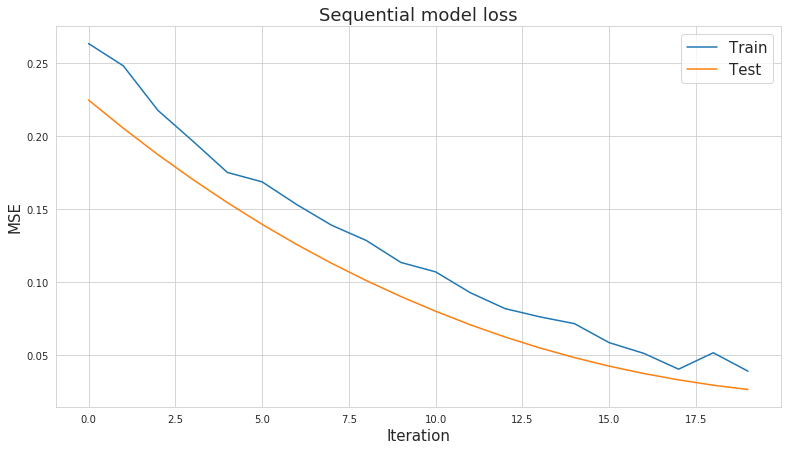

In [51]:
plt.figure(figsize=(13,7))
plt.plot(yfit.history['loss'])
plt.plot(yfit.history['val_loss'])
plt.title('Sequential model loss', fontsize=18)
plt.ylabel('MSE', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper right', fontsize=15)
plt.show()

### Timeframe aggregated predictions

Test RMSE: 0.263


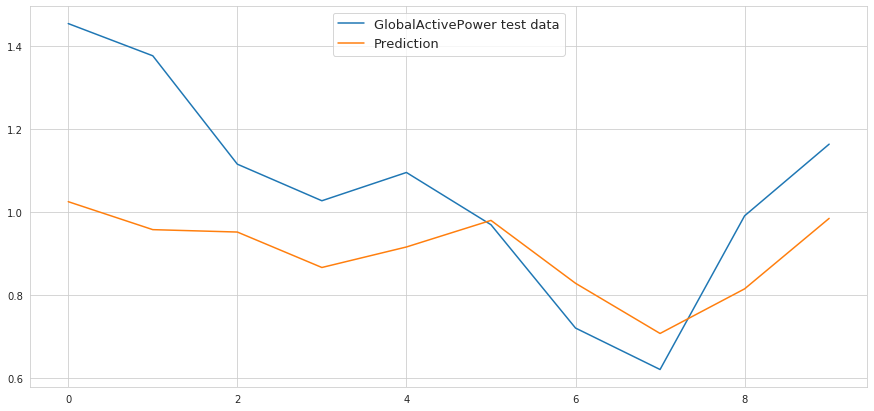

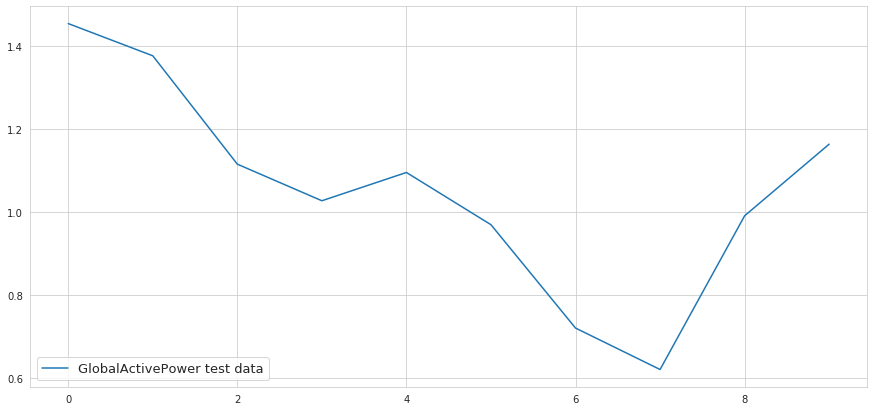

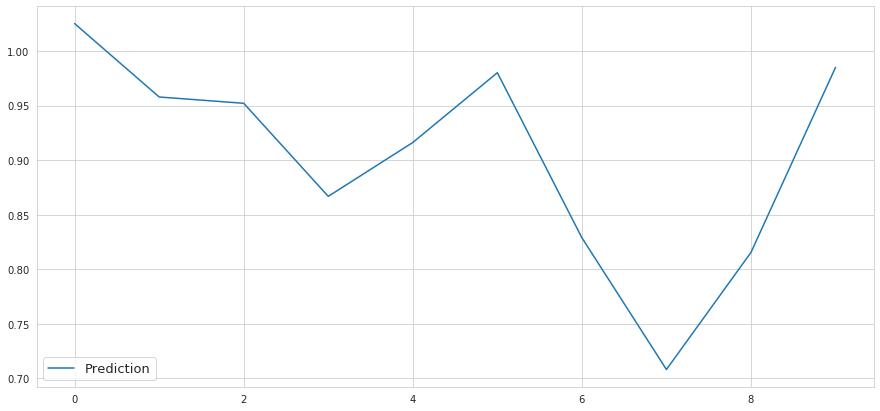

In [52]:
yhat = model.predict(test_X)
X_test = test_X.reshape((test_X.shape[0], 8))
X_test.shape

inv_yhat = np.concatenate((yhat, X_test[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, X_test[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(15,7))
x = np.arange(len(inv_y))
plt.plot(x[0:-1],inv_y[0:-1], label="GlobalActivePower test data")
plt.plot(x[0:-1],inv_yhat[1:], label="Prediction")
plt.legend(fontsize=13, loc='upper center')
plt.show()

plt.figure(figsize=(15,7))
plt.plot(x[0:-1],inv_y[0:-1], label="GlobalActivePower test data")
plt.legend(fontsize=13, loc='lower left')
plt.show()
plt.figure(figsize=(15,7))
plt.plot(x[0:-1],inv_yhat[1:], label="Prediction")
plt.legend(fontsize=13, loc='lower left')
plt.show()